# Pomnażanie obrazów i przenoszenie nauki

In [1]:
import os

# Ustawienie PyTorch jako zaplecza dla biblioteki Keras
os.environ["KERAS_BACKEND"] = "torch"
import torch
import keras
from keras import layers, datasets

import numpy as np
import PIL.Image as Image
import matplotlib.pylab as plt

# Sprawdzenie dostępności GPU
#print(tf.config.list_physical_devices('GPU'))
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    if torch.xpu.is_available():
        for i in range(torch.xpu.device_count()):
            print(f"XPU {i}: {torch.xpu.get_device_name(i)}")
    else:
        print("Brak dostępnych GPU lub XPU.")
        print("Używam CPU.")

GPU 0: Tesla T4


In [10]:
IMAGE_SIZE = 96 #299
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)
num_classes = 10

(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [22]:
def build_model(classifier):

    classifier.trainable = True  # Unfreeze the base model for fine-tuning
    # Create new model on top
    inputs = keras.Input(shape=(28, 28, 1))
    x = keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)(inputs)  # Resize input to match the base model
    x = keras.layers.Concatenate()([x,x,x])
    # Simple data augmentation
    x = keras.layers.RandomFlip("horizontal")(x)
    x = keras.layers.RandomRotation(0.5)(x)
    x = keras.layers.RandomColorJitter()(x)
    x = keras.layers.RandomSharpness(0.66)(x)
    # The base model contains batchnorm layers. We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base_model is running in inference mode here.
    x = classifier(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    outputs = keras.layers.Dense(num_classes)(x)
    model = keras.Model(inputs, outputs)

    model.summary(show_trainable=True)

    return model

finetune_net = build_model(keras.applications.ResNet50V2(
                                                    weights="imagenet",
                                                    include_top=False,
                                                    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

scratch_net = build_model(keras.applications.ResNet50V2(
                                                    weights=None,
                                                    include_top=False,
                                                    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_29    │ (None, 28, 28,  │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ resizing_14       │ (None, 96, 96,  │         0 │ input_layer_2… │   -   │
│ (Resizing)        │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ concatenate_14    │ (None, 96, 96,  │         0 │ resizing_14[0… │   -   │
│ (Concatenate)     │ 3)              │           │ resizing_14[0… │       │
│                   │                 │           │ resizing_14[0… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ random_flip_10    │ (None, 96, 96,  │         0 │ concatenate_1… │   -   │
│ (RandomFlip)      │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ random_rotation_2 │ (None, 96, 96,  │         0 │ random_flip_1… │   -   │
│ (RandomRotation)  │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ random_color_jit… │ (None, 96, 96,  │         0 │ random_rotati… │   -   │
│ (RandomColorJitt… │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ random_sharpness… │ (None, 96, 96,  │         0 │ random_color_… │   -   │
│ (RandomSharpness) │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ resnet50v2        │ (None, 3, 3,    │ 23,564,8… │ random_sharpn… │   Y   │
│ (Functional)      │ 2048)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ global_average_p… │ (None, 2048)    │         0 │ resnet50v2[0]… │   -   │
│ (GlobalAveragePo… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout_14        │ (None, 2048)    │         0 │ global_averag… │   -   │
│ (Dropout)         │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense_14 (Dense)  │ (None, 10)      │    20,490 │ dropout_14[0]… │   Y   │
└───────────────────┴─────────────────┴───────────┴────────────────┴───────┘

 Total params: 23,585,290 (89.97 MB)

 Trainable params: 23,539,850 (89.80 MB)

 Non-trainable params: 45,440 (177.50 KB)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_31    │ (None, 28, 28,  │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ resizing_15       │ (None, 96, 96,  │         0 │ input_layer_3… │   -   │
│ (Resizing)        │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ concatenate_15    │ (None, 96, 96,  │         0 │ resizing_15[0… │   -   │
│ (Concatenate)     │ 3)              │           │ resizing_15[0… │       │
│                   │                 │           │ resizing_15[0… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ random_flip_11    │ (None, 96, 96,  │         0 │ concatenate_1… │   -   │
│ (RandomFlip)      │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ random_rotation_3 │ (None, 96, 96,  │         0 │ random_flip_1… │   -   │
│ (RandomRotation)  │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ random_color_jit… │ (None, 96, 96,  │         0 │ random_rotati… │   -   │
│ (RandomColorJitt… │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ random_sharpness… │ (None, 96, 96,  │         0 │ random_color_… │   -   │
│ (RandomSharpness) │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ resnet50v2        │ (None, 3, 3,    │ 23,564,8… │ random_sharpn… │   Y   │
│ (Functional)      │ 2048)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ global_average_p… │ (None, 2048)    │         0 │ resnet50v2[0]… │   -   │
│ (GlobalAveragePo… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout_15        │ (None, 2048)    │         0 │ global_averag… │   -   │
│ (Dropout)         │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense_15 (Dense)  │ (None, 10)      │    20,490 │ dropout_15[0]… │   Y   │
└───────────────────┴─────────────────┴───────────┴────────────────┴───────┘

 Total params: 23,585,290 (89.97 MB)

 Trainable params: 23,539,850 (89.80 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [23]:
# Compile the model for multiclass classification
finetune_net.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# Train the model
history = finetune_net.fit(
    train_images, train_labels,
    epochs=5,
    batch_size=256,
    validation_data=(test_images, test_labels),
)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.1309 - loss: 2.4700 - val_accuracy: 0.1000 - val_loss: 921910.8125
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.1340 - loss: 2.2827 - val_accuracy: 0.1118 - val_loss: 82763.8906
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.1248 - loss: 2.2995 - val_accuracy: 0.1301 - val_loss: 2.2423
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.1705 - loss: 2.1878 - val_accuracy: 0.0800 - val_loss: 2.4603
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.4055 - loss: 1.5441 - val_accuracy: 0.2599 - val_loss: 6.2545


313/313 - 20s - 64ms/step - accuracy: 0.2599 - loss: 6.2545


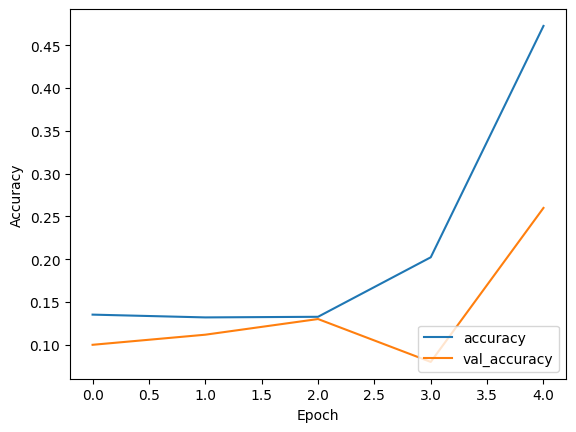

In [26]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = finetune_net.evaluate(test_images,  test_labels, verbose=2)

## Zadania

1. Wytrenuj model bez pomnażania obrazów. Porównaj celność treningową jak też i testową z oraz bez pomnażania obrazów. Czy ten eksperyment porównawczy popiera argument, że pomnażanie obrazów może ograniczać nadmierne dopasowanie? Dlaczego?
2. Wymieszaj różne metody poszerzania zbiorów danych na zbiorze CIFAR-10. Czy poprawiaja one celność?
3. Zwiększ współczynnik uczenia w `finetune_net`. Jak zmieni się celność predykcji modelu?
4. Kontynuuj dostosowywanie hiperparametrów obu sieci w eksperymencie porównawczym. Czy nadal ich trafność predykcji różni się?
5. Ustaw parametry wszystkich warstw z wyjątkiem wyjściowej w siei `finetune_net` na te ze źródłowego modelu i nie aktualizuj ich podczas trningu. Jak zmieni się celność modelu?